In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, ConfusionMatrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

In [6]:
train = DataLoader(train_dataset, batch_size=64, shuffle=True)
val = DataLoader(val_dataset, batch_size= 1000, shuffle=True)
test = DataLoader(test_dataset, batch_size= 1000, shuffle=True)

### Linear Model

In [7]:
class MNISTLinear(nn.Module) :
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(28 * 28, 128)
        self.FC2 = nn.Linear(128, 64)
        self.FC3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.FC1(x))
        x = F.relu(self.FC2(x))
        return F.log_softmax(self.FC3(x), dim=1)

### CNN Model

In [8]:
class MNISTClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_block = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return F.log_softmax(x, dim=1)

### Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LinearModel = MNISTLinear().to(device)
loss_fn_Linear = nn.CrossEntropyLoss()
optimizer_Linear = optim.AdamW(LinearModel.parameters())

CNNmodel = MNISTClassification().to(device)
loss_fn_CNN = nn.CrossEntropyLoss()
optimizer_CNN = optim.AdamW(CNNmodel.parameters())

In [10]:
def train_model(model, loss_fn, optimizer) :
    for epoch in range(10) :
        model.train()
        train_loss = 0

        loop = tqdm(train, desc=f"Epoch {epoch+1}/{10} [Training]", leave=False)
        for images, labels in loop :
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        model.eval()
        val_loss = 0
        f1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
        accuracy = MulticlassAccuracy(num_classes=10, average='macro').to(device)

        with torch.no_grad() :
            val_loop = tqdm(val, desc=f"Epoch {epoch+1}/{10} [Validation]", leave=False)
            for images, labels in val_loop :
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_loop.set_postfix(loss=loss.item())

                f1.update(preds, labels)
                accuracy.update(preds, labels)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train):.4f} | "
            f"Val Loss: {val_loss/len(val):.4f} | Val F1: {f1.compute():.4f} | Val Acc: {accuracy.compute():.4f}")
    



In [11]:
train_model(LinearModel, loss_fn_Linear, optimizer_Linear)

Epoch 1 | Train Loss: 0.4222 | Val Loss: 0.2485 | Val F1: 0.9265 | Val Acc: 0.9270


Epoch 2 | Train Loss: 0.2054 | Val Loss: 0.1841 | Val F1: 0.9440 | Val Acc: 0.9437


Epoch 3 | Train Loss: 0.1558 | Val Loss: 0.1571 | Val F1: 0.9527 | Val Acc: 0.9524


Epoch 4 | Train Loss: 0.1248 | Val Loss: 0.1279 | Val F1: 0.9604 | Val Acc: 0.9602


Epoch 5 | Train Loss: 0.1045 | Val Loss: 0.1089 | Val F1: 0.9663 | Val Acc: 0.9662


Epoch 6 | Train Loss: 0.0923 | Val Loss: 0.1462 | Val F1: 0.9552 | Val Acc: 0.9551


Epoch 7 | Train Loss: 0.0817 | Val Loss: 0.1186 | Val F1: 0.9649 | Val Acc: 0.9654


Epoch 8 | Train Loss: 0.0729 | Val Loss: 0.1149 | Val F1: 0.9638 | Val Acc: 0.9643


Epoch 9 | Train Loss: 0.0679 | Val Loss: 0.1043 | Val F1: 0.9683 | Val Acc: 0.9680


Epoch 10 | Train Loss: 0.0620 | Val Loss: 0.1115 | Val F1: 0.9670 | Val Acc: 0.9667


In [12]:
train_model(CNNmodel, loss_fn_CNN, optimizer_CNN)

Epoch 1 | Train Loss: 0.5904 | Val Loss: 0.1321 | Val F1: 0.9615 | Val Acc: 0.9614


Epoch 2 | Train Loss: 0.2582 | Val Loss: 0.0935 | Val F1: 0.9722 | Val Acc: 0.9723


Epoch 3 | Train Loss: 0.2092 | Val Loss: 0.0840 | Val F1: 0.9767 | Val Acc: 0.9767


Epoch 4 | Train Loss: 0.1873 | Val Loss: 0.0714 | Val F1: 0.9787 | Val Acc: 0.9786


Epoch 5 | Train Loss: 0.1734 | Val Loss: 0.0692 | Val F1: 0.9797 | Val Acc: 0.9797


Epoch 6 | Train Loss: 0.1617 | Val Loss: 0.0618 | Val F1: 0.9822 | Val Acc: 0.9822


Epoch 7 | Train Loss: 0.1560 | Val Loss: 0.0598 | Val F1: 0.9823 | Val Acc: 0.9823


Epoch 8 | Train Loss: 0.1451 | Val Loss: 0.0595 | Val F1: 0.9836 | Val Acc: 0.9836


Epoch 9 | Train Loss: 0.1414 | Val Loss: 0.0580 | Val F1: 0.9833 | Val Acc: 0.9833


Epoch 10 | Train Loss: 0.1402 | Val Loss: 0.0579 | Val F1: 0.9832 | Val Acc: 0.9832


### Test verification

In [13]:
def creat_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75})

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [14]:
def test_verification(model) :
    f1_test = MulticlassF1Score(num_classes=10, average='macro').to(device)
    accuracy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
    CF = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

    with torch.no_grad() :
        for images, labels in test :
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            f1_test.update(output, labels)
            accuracy_test.update(output, labels)
            CF.update(output, labels)

    print(f"Test Accuracy:{accuracy_test.compute():.4f} | Test F1:{f1_test.compute():.4f}")
    creat_heatmap(CF)

Test Accuracy:0.9693 | Test F1:0.9695


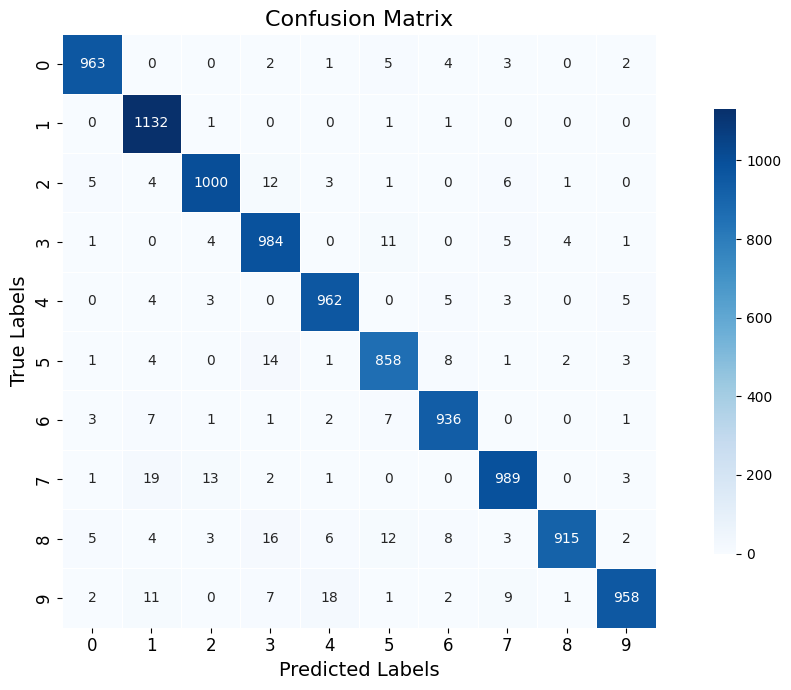

In [15]:
test_verification(LinearModel)

Test Accuracy:0.9861 | Test F1:0.9862


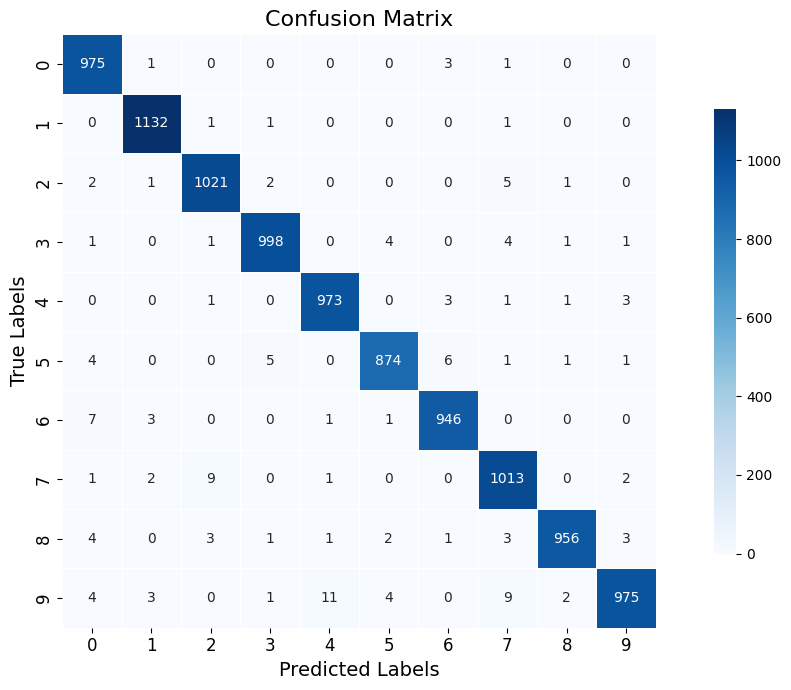

In [16]:
test_verification(CNNmodel)

# Training Results

## 📊 1. Linear Model

| Epoch | Train Loss | Val Loss | Val F1 | Val Acc |
| :---: | :--------: | :------: | :----: | :-----: |
|   1   |   0.4222   |  0.2485  | 0.9265 |  0.9270 |
|   2   |   0.2054   |  0.1841  | 0.9440 |  0.9437 |
|   3   |   0.1558   |  0.1571  | 0.9527 |  0.9524 |
|   4   |   0.1248   |  0.1279  | 0.9604 |  0.9602 |
|   5   |   0.1045   |  0.1089  | 0.9663 |  0.9662 |
|   6   |   0.0923   |  0.1462  | 0.9552 |  0.9551 |
|   7   |   0.0817   |  0.1186  | 0.9649 |  0.9654 |
|   8   |   0.0729   |  0.1149  | 0.9638 |  0.9643 |
|   9   |   0.0679   |  0.1043  | 0.9683 |  0.9680 |
|   10  |   0.0620   |  0.1115  | 0.9670 |  0.9667 |

**🎯 Test Accuracy:** `0.9693`
**🎯 Test F1 Score:** `0.9695`

---

## 🧠 2. CNN Model

| Epoch | Train Loss | Val Loss | Val F1 | Val Acc |
| :---: | :--------: | :------: | :----: | :-----: |
|   1   |   0.5904   |  0.1321  | 0.9615 |  0.9614 |
|   2   |   0.2582   |  0.0935  | 0.9722 |  0.9723 |
|   3   |   0.2092   |  0.0840  | 0.9767 |  0.9767 |
|   4   |   0.1873   |  0.0714  | 0.9787 |  0.9786 |
|   5   |   0.1734   |  0.0692  | 0.9797 |  0.9797 |
|   6   |   0.1617   |  0.0618  | 0.9822 |  0.9822 |
|   7   |   0.1560   |  0.0598  | 0.9823 |  0.9823 |
|   8   |   0.1451   |  0.0595  | 0.9836 |  0.9836 |
|   9   |   0.1414   |  0.0580  | 0.9833 |  0.9833 |
|   10  |   0.1402   |  0.0579  | 0.9832 |  0.9832 |

**🎯 Test Accuracy:** `0.9861`
**🎯 Test F1 Score:** `0.9862`

---

## 🔍 Final Comparison

| Metric        | 🧮 Linear Model | 🧠 CNN Model           |
| ------------- | --------------- | ---------------------- |
| Final Val Acc | 0.9667          | 0.9832                 |
| Final Val F1  | 0.9670          | 0.9832                 |
| Test Accuracy | 0.9629          | 0.9861                 |
| Test F1 Score | 0.9628          | 0.9862                 |
| Convergence   | Slower          | Faster                 |
| Model Size    | Smaller         | Larger                 |
| Feature Use   | Raw Pixels      | Local Spatial Patterns |

---

## ✅ Summary

* The **CNN model** still significantly outperforms the **Linear model**, especially in terms of generalization on the test set.
* CNN’s convolutional layers help it extract local spatial features, making it more effective and quicker to converge.
* The **Linear model**, although less accurate, is simpler and may be suitable for fast prototyping or deployment in resource-constrained environments.
